# Motor de Corriente Continua e imán permanente: Modelado del sistema

Principales comando de Python usados: 
**pyhton-control:** NonlinearIOSystem, input_output_response, ss, tf, forced_response
**numpy:** linspace, arange, array, eye, zero, ones
**matplotlib:** subplots, plot, set_xlabel, set_ylabel, grid, suptitle, tight_layout

<div class="alert alert-block alert-warning">
<b>Warning: </b> El siguiente notebook fue ejecutado con las versiones de la librería de python-control:  0.9.1:
</div> 

- [Modelo físico](#id_motor1)
    - [Descripción y su funcionamiento](#id_motor1_1)
    - [Parámetros de las ecuaciones del sistema](#id_motor1_2)
    - [Desarrollo de las ecuaciones](#id_motor1_3)
    - [Simulación del modelo usando python-control: IOmodel](#id_motor1_4)
- [Modelo en espacio de estados](#id_motor3)
    - [Simulación de la dinámica del motor: SSmodel](#id_motor3_1)
- [Modelo en función de transferencia](#id_motor4)
    - [Simulación de la dinámica del motor: TFmodel](#id_motor4_1)
- [Citas y Referencias](#id_motor5)



<a id="id_motor1"></a>
## Modelo físico

<a id="id_motor1_1"></a>
### Descripción y su funcionamiento

A continuación se deja un video describiendo las partes de un motor y la forma de funcionamiento. Si bien el motor del video es un motor de ambas corrientes o motor universal de corriente alterna, a los fines prácticos es similar al un motor de continua desde el punto de vista mecánico.

[![motor: descripción](motor_parte0.png)](https://youtu.be/ztMgB1UofxU "Motor eléctrico: descripción")

<a id="id_motor1_2"></a>
### Parámetros de las ecuaciones del sistema

- $R_a= 4 [Ohm]$ resistencia equivalente del bobinado de armadura
- $L_a= 2.75E-6 [H]$ inductancia equivalente del bobinado de armadura
- $K= 0.0274 [Nm/A]$ constante del motor
- $J_m= 3.2284E-6 [kg m^2]$ Inercia del motor 
- $D_m= 3.5077E-6 [N m s]$ Coeficiente de fricción viscosa total (rodamientos y escobillas)

<!---
Jm = 4.178;
Dm = 0.9827;
K = 2.68;
Ra = 3.6;
La = 2.75e-6;
--->

El modelo matemático se obtiene planteando las ecuaciones físicas del circuito eléctrico equivalente y del modelo mecánico planteado.

La primera ecuación a plantear es la que corresponde al circuito equivalente de la Armadura. Esta ecuación surge de aplicar las ecuaciones de Kirchoff.

La segunda ecuación corresponde al modelo mecánico planteado. La ecuación surge de aplicar la segunda ley de Newton.

Algunas  simplificaciones que consideraremos para este modelo son:

1. La resistencia, inductancia, momento de inercia y "viscosidad" son constantes. Es decir, no contemplaremos cambios de ningún tipo, como por ejemplo el efecto de la temperatura.
1. El rozamiento viscoso es lineal. Es decir, la viscosidad es es proporcional a la velocidad ($\tau_d=D_m*\omega$).

<img src="motor_fig1.png">


<a id="id_motor1_3"></a>
### Desarrollo de las ecuaciones

El circuito eléctrico se relaciona con el mecánico, y viceversa, por medio de la siguientes ecuaciones:

$$
\begin{aligned}
V_b(t) &= K_b \frac{d\theta_m(t)}{dt} &\text{fuerza contraelectromotriz}\\
 \tau_m(t) &= K_t i_a(t) &\text{torque del motor}
\end{aligned}
$$

para las mismas unidades $K_t = K_b$

$$
\begin{aligned}
R_a i_a(t) + L_a \frac{di_a(t)}{dt} + V_b(t) &= e_a(t) & \text{Ec. de la malla eléctrica de la armadura}\\
\tau_m(t) - \tau_r(t) - D_m\frac{d\theta_m(t)}{dt} &= J_m \frac{d^2\theta_m(t)}{dt^2} & \text{Ecs. mecánica}
\end{aligned}
$$

Reemplazando obtenemos el sistema de ecuaciones de parámetros concentrados (no depende de la ubicación espacial de los componentes del sistema), lineal (cumple con superposición) e invariante en el tiempo (su comportamiento no cambia con el tiempo). Como el sistema es lineal e invariante en el tiempo se dice que el sistema es LTI (linear time invariant).

<div class="alert alert-block alert-info">
<b>Ecuaciones lineales:<b/>
<br/>
<br/>
$$
\begin{aligned}
 \frac{di_a(t)}{dt} &= -\frac{R_a}{L_a} i_a(t) - \frac{K_b}{L_a} \frac{d\theta_m(t)}{dt}+\frac{1}{L_a} e_a(t) \\
\frac{d^2\theta_m(t)}{dt^2} &= \frac{K_t}{J_m} i_a(t)  - \frac{D_m}{J_m}\frac{d\theta_m(t)}{dt}- \frac{1}{J_m}\tau_r(t)
\end{aligned}
$$
</div>

<a id="id_motor1_4"></a>
### Simulación del modelo usando python-control: IOmodel

In [1]:
import control as ctrl
import matplotlib.pyplot as plt
import numpy as np

#es necesario versión 0.9.1 de la biblioteca de control
print('version de biblioteca de control: ', ctrl.__version__)

# definición de parámetros del motor para los distintos modelos
Jm = 3.2284E-6;
Dm = 3.5077E-6;
K = 0.0274;
Ra = 4;
La = 2.75E-6;

version de biblioteca de control:  0.9.1


Para la simulación es necesario definir una función con las funciones de la derivadas y en este caso también se define una función para la salida aunque esta última no es necesaria (se podría usar solo `motor_update` con la salida de `motor_output`).

In [2]:
def motor_update(t, x, u, params={}):
    # Parámetros, tienen valores por defecto
    Jm =params.get('Jm', 3.2284E-6)
    Dm =params.get('Dm', 3.5077E-6)
    K =params.get('K', 0.0274)
    Ra =params.get('Ra', 4)
    La =params.get('La', 2.75E-6)
    
    Ea,Tr= u[0],u[1]
    # variables de estado
    ia = x[0]#x1
    dtheta = x[1]#x2 = dx3/dt
    theta = x[2] #x3 
    
    #calculo de la derivadas
    ddtheta=(K/Jm*ia-Dm/Jm*dtheta)#-1/Jm*Tr)
    dia = (1/La*Ea  - Ra/La*ia -K/La *dtheta) #x1/dt
    return dia, ddtheta, dtheta

def motor_output(t, x, u, params={}): 
    return x[2],x[1]


Si bien este sistema es lineal, como lo definimos anteriormente, usamos la función `NonlinearIOSystem` en lugar de `LinearIOSystem`, podríamos agregarle alinealidades propias del motor como _Backlash_ o saturación en la variable de control, por ejemplo, $u_{max} = 24V$ y $u_{min} = -24V$

In [3]:
io_motor = ctrl.NonlinearIOSystem(motor_update ,motor_output,name='motor_dc',
                                  inputs=('Ea','Tr'), outputs=('theta','dtheta'),
                                 states=('ia','dtheta','theta'))

En este caso estamos ante un sistema _stiff_, esto es porque hay dos modos con dinamicas muy distintas, por un lado el modo que responde a la mecánica que es mucho mas lenta que la dinámica del modo eléctrico, por este motivo fue necesario definir el método de integración distinto al método por defecto (Radau).

In [4]:
T = np.linspace(0, .2, 501)
U =np.array([np.ones(501),np.zeros(501)])

t, y = ctrl.input_output_response(io_motor, T, U, [0,0,0],solve_ivp_method='Radau')

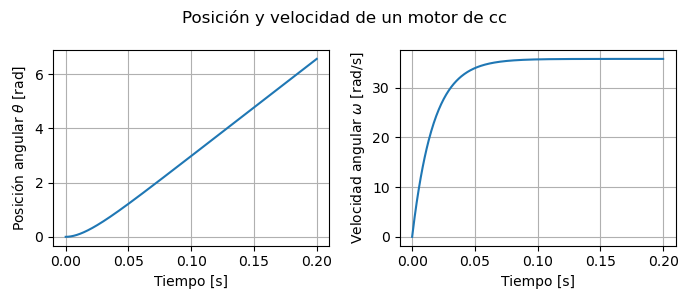

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# (a) - 
ax = axes[0]
ax.plot(t, y[0,:])
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Posición angular $\theta$ [rad]')
ax.grid()

# (b) - 
ax = axes[1]
ax.plot(t, y[1,:])
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Velocidad angular $\omega$ [rad/s]')
ax.grid()

plt.suptitle('Posición y velocidad de un motor de cc')
plt.tight_layout()

<a id="id_motor3"></a>
## Modelo en Espacio de Estados

El sistema se representa con tres variables de estado, una por la parte eléctrica, donde el elemento que acumula energía es la bobina y el orden de la ecuación es uno, y dos por la parte mecánica, donde los modos que acumlan energía y el orden de la ecuación, es dos, la inercia y el rozamiento. En este caso, el modelo se representa con dos entradas, la de control $e_a(t)$y la perturbación $\tau_r(t)$(no controlada). Donde:

$$
\begin{aligned}
 \frac{di_a(t)}{dt} &= -\frac{R_a}{L_a} i_a(t) - \frac{K}{L_a} \frac{d\theta_m(t)}{dt}+\frac{1}{L_a} e_a(t) \\
\frac{d^2\theta_m(t)}{dt^2} &= \frac{K}{J_m} i_a(t)  - \frac{D_m}{J_m}\frac{d\theta_m(t)}{dt}- \frac{1}{J_m}\tau_r(t)
\end{aligned}
$$

Luego consideraremos las siguiente variables de estado:
$$
\mathbf{x_1(t)}= i_a(t) \rightarrow \dot{\mathbf{x_1}}(t)= \frac{di_a(t)}{dt}\newline
\mathbf{x_2(t)}= \frac{d\theta_m(t)}{dt} \rightarrow \dot{\mathbf{x_2}}(t)= \frac{d^2\theta_m(t)}{dt^2}\newline
\mathbf{x_3(t)}= \theta_m(t) \rightarrow \dot{\mathbf{x_3}}(t)= \frac{d\theta_m(t)}{dt}\newline
\mathbf{u(t)}=e_a(t)\newline
\mathbf{d(t)}=\tau_r(t)
$$

<div class="alert alert-block alert-info">
Por lo que, la representación en <b>variables de estado</b> se puede escribir:
<br/>
<br/>
$$
\begin{split}
\left[{\begin{array}{c}\dot{\mathbf{x_1}} \\ \dot{\mathbf{x_2}} \\ \dot{\mathbf{x_3}}\end{array}}\right] 
&=
\left[{\begin{array}{c} -\frac{R_a}{L_a}  &&  - \frac{K}{L_a} && 0 \\ \frac{K}{J_m} &&  - \frac{D_m}{J_m} && 0 \\ 0 && 1 && 0 \end{array}}\right] \left[{\begin{array}{c}\mathbf{x_1} \\ \mathbf{x_2} \\ \mathbf{x_3}\end{array}}\right] + \left[{\begin{array}{c}\frac{1}{L_a} \\ 0 \\ 0\end{array}}\right][\mathbf{u}]  + \left[{\begin{array}{c}0 \\ \frac{1}{J_m} \\0 \end{array}}\right][\mathbf{d}] \newline
y&=\left[{\begin{array}{c} 1 && 0 && 0\\0 && 1 && 0\\0 && 0 && 1\end{array}}\right]\left[{\begin{array}{c}\mathbf{x_1} \\ \mathbf{x_2} \\ \mathbf{x_3}\end{array}}\right]
\end{split}
$$
    
También se puede escribir:
    
$$
\begin{split}
\left[{\begin{array}{c}\dot{\mathbf{x_1}} \\ \dot{\mathbf{x_2}} \\ \dot{\mathbf{x_3}}\end{array}}\right] 
&=
\left[{\begin{array}{c} -\frac{R_a}{L_a}  &&  - \frac{K}{L_a} && 0 \\ \frac{K}{J_m} &&  - \frac{D_m}{J_m} && 0 \\ 0 && 1 && 0 \end{array}}\right] \left[{\begin{array}{c}\mathbf{x_1} \\ \mathbf{x_2} \\ \mathbf{x_3}\end{array}}\right] + \left[{\begin{array}{c}\frac{1}{L_a} && 0 \\ 0 && \frac{1}{J_m} \\ 0 && 0 \end{array}}\right]\left[{\begin{array}{c}\mathbf{u} && \mathbf{d}\end{array}}\right]\newline
\end{split}
$$

</div>

<a id="id_motor3_1"></a>
### Simulación de la dinámica del motor: SSmodel

In [6]:
A = [ [-Ra/La, -K/La ,  0],
      [ K/Jm , -Dm/Jm,  0],
      [  0   ,   1   ,  0] ];

B = [ [1/La ,  0  ],
      [0    , 1/Jm],
      [0    ,  0  ] ];

C = np.eye(3);

D = np.zeros((3,2))

motor_ss= ctrl.ss(A,B,C,D)
motor_ss

StateSpace(array([[-1.45454545e+06, -9.96363636e+03,  0.00000000e+00],
       [ 8.48717631e+03, -1.08651344e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00]]), array([[363636.36363636,      0.        ],
       [     0.        , 309750.96022798],
       [     0.        ,      0.        ]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[0., 0.],
       [0., 0.],
       [0., 0.]]))

Hay muchas formas de hacer la siguiente simulación, usamos `forced_response`, porque es la más completa y complicada de usar, también se puede usar `step_response` que es una una función derivada de la anterior. En este caso usamos la matriz $C$ como la identidad para medir las tres variables de estado por separado, obserbar que en este caso $y$ es un vector columna con tres señales, como se puede ver en la gráfica siguiente.

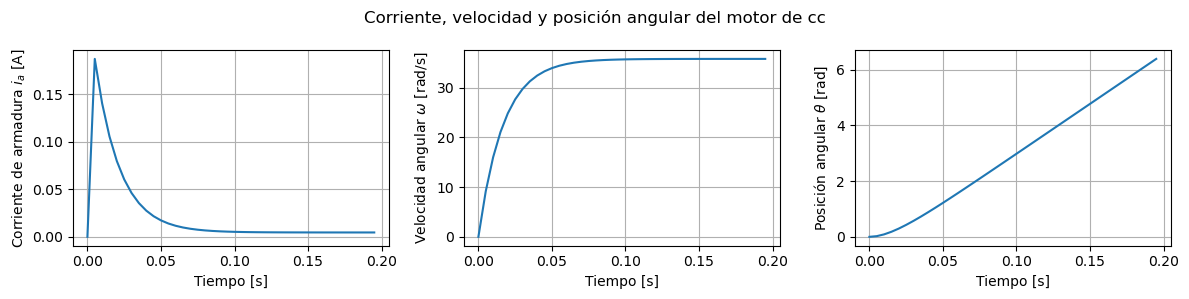

In [7]:
t = np.arange(0,.2,0.005)
u = np.ones(t.size)
d = np.zeros(t.size)
x0 = [0, 0, 0]

t,yy,x = ctrl.forced_response(motor_ss,U=[u,d],T=t,X0=x0,return_x=True);

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

# (a) - 
ax = axes[0]
ax.plot(t, yy[0,:])
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Corriente de armadura $i_a$ [A]')
ax.grid()

# (b) - 
ax = axes[1]
ax.plot(t, yy[1,:])
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Velocidad angular $\omega$ [rad/s]')
ax.grid()

# (c) - 
ax = axes[2]
ax.plot(t, yy[2,:])
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Posición angular $\theta$ [rad]')
ax.grid()

plt.suptitle('Corriente, velocidad y posición angular del motor de cc')
plt.tight_layout()

<a id="id_motor4"></a>
## Función de transferencia

Supongamos CI nulas, es decir $i_a(t=0)=0$ y $(\theta_m(t=0)=0)$ entonces de las ecuaciones del motor obtenidas en ejemplos anteriores y aplicando la transformada de Laplace, tenemos:

$$ 
\left\{\begin{array}{c}
s~I_a(s) = \frac{1}{L_a} E_a(s) -\frac{ R_a}{L_a} I_a(s) -  \frac{K_b}{L_a} s~\Theta_m(s)  \\
s^2~\Theta_m(s) =   \frac{K_t}{J_m} I_a(s) - \frac{D_m}{J_m}s~\Theta_m(s) - \frac{1}{J_m} T_r(s)
\end{array}\right.
$$

agrupando las variables y despejando de la segunda ecuación la corriente $I_a(s)$:

$$ 
\begin{aligned}
 I_a(s) &= \frac{J_m}{K_t}\left(s^2+ \frac{D_m}{J_m}s\right)~\Theta_m(s) + \frac{1}{K_t} T_r(s)
\end{aligned}
$$

Este sistema tiene dos entradas, la entrada que podemos controlar $E_a(s)$ y la entrada de perturbación $T_r(s)$, por ser un sistema LTI podemos hallar las FTs de la siguiente forma, primero considerando $T_r=0$, hallamos la FT desde la entrada $E_a$ a la salida $\Theta_m$:

$$ 
\frac{\Theta_m(s)} {E_a(s)}  = \frac{\frac{1}{L_a}}{\left(s+ \frac{ R_a}{L_a}\right)\frac{J_m}{K_t}\left(s^2+ \frac{D_m}{J_m}s\right)+\frac{K_b}{L_a} s}  
$$

finalmente si consideramos que $E_a=0$, hallamos la FT desde la entrada de perturbación $T_r$ a la salida $\Theta_m$:

$$
\frac{\Theta_m(s)} {T_r(s)}  =- \frac{\left(s+ \frac{ R_a}{L_a}\right)\frac{1}{K_t} }{\left(s+ \frac{ R_a}{L_a}\right)\frac{J_m}{K_t}\left(s^2+ \frac{D_m}{J_m}s\right)+\frac{K_b}{L_a} s}
$$

<a id="id_motor4_1"></a>
### Simulación de la dinámica del motor: TFmodel

In [8]:
s = ctrl.tf('s');
E2theta = 1/La/((s+Ra/La)*Jm/K*(s**2+Dm/Jm*s)+K/La*s)
E2theta

TransferFunction(array([9963.63636364]), array([3.22840000e-06, 4.69585805e+00, 2.78105745e+02, 0.00000000e+00]))

In [9]:
E2dtheta = 1/La/((s+Ra/La)*Jm/K*(s+Dm/Jm)+K/La)
E2dtheta

TransferFunction(array([9963.63636364]), array([3.22840000e-06, 4.69585805e+00, 2.78105745e+02]))

In [10]:
t,theta=ctrl.step_response(E2theta,T)
t,dtheta=ctrl.step_response(E2dtheta,T)

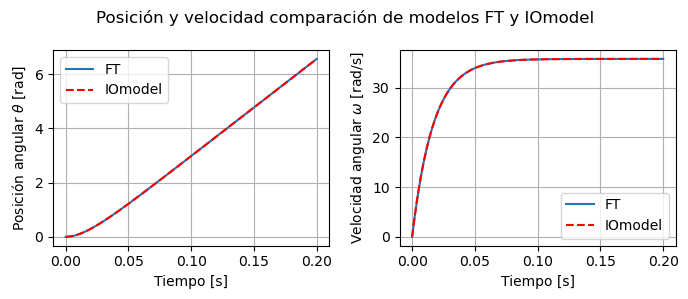

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# (a) - Posición TF y IOmodel
ax = axes[0]
ax.plot(t,theta)
ax.plot(t, y[0,:],'r--')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Posición angular $\theta$ [rad]')
ax.legend(['FT','IOmodel'])
ax.grid()

# (b) - 
ax = axes[1]
ax.plot(t,dtheta)
ax.plot(t, y[1,:],'r--')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel(r'Velocidad angular $\omega$ [rad/s]')
ax.legend(['FT','IOmodel'])
ax.grid()

plt.suptitle('Posición y velocidad comparación de modelos FT y IOmodel')
plt.tight_layout()

<a id="id_motor5"></a>
## Citas y Referencias:

<div class="alert alert-block alert-info">
<b></b> Por ahora dejo las citas y referencia con este formato, si encuentro algo mejor lo cambio.
</div>


___
<a id="cite1"></a>
**REF#1: Control Tutorials for Matlab & Simulink**.

title = Introduction: State-Space Methods for Controller Design.   
url = https://ctms.engin.umich.edu/CTMS/index.php?example=MotorPosition&section=SystemModeling    
note = Accessed: 2022-11-29   

___
<a id="cite2"></a>
**REF#2: Apuntes de Control Clásico y Variables de Estado**   

autor = Molina, Gonzalo  
url = https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/laplace/funcion_transferencia.html
note = Accessed: 2022-11-29      

___

    
<!--bibtex
@misc{ctms,
  title = {{Control Tutorials for Matlab & Simulink} Introduction: State-Space Methods for Controller Design},
  howpublished = {\url{https://ctms.engin.umich.edu/CTMS/index.php?example=Introduction&section=ControlStateSpace}},
  note = {Accessed: 2022-04-18}
  

@misc{CCyVE,
  title = {{Apuntes de Control Clásico y Variables de Estado} Linealización},
  author = {Molina, Gonzalo},
  howpublished = \url{https://gonmolina.github.io/CCyVE_book/sources/notebooks_sources/modulo1/linealizacion/linealizacion.html}},
  note = {Accessed: 2022-04-18}
  
 -->

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Licencia Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Licencia Creative Commons Atribución 4.0 Internacional</a>.